# Imports

In [3]:
# EXTERNAL LIBRARIES
import numpy as np
import matplotlib.pyplot as plt
import torch
import yaml
from pathlib import Path
import os
import sys

# MY SCRIPTS
sys.path.append('functions/') # scripts folder
import plots
import system as syst
import qammod as qmd
import papreduce as prd
import ccdf as ccdf
import file as f

# Detect if we are in Google Colaboratory
try:
    import google.colab
    IN_COLAB = True
    print('You are going to use GOOGLE COLAB')
except ImportError:
    IN_COLAB = False
    print('You are going to use LOCAL MACHINE')

# Add path for scripts and files directory
if IN_COLAB:
    google.colab.drive.mount("/content/drive")
    AUX_DATA_ROOT = Path("/content/drive/My Drive/PAPR reduction/Code")
    assert AUX_DATA_ROOT.is_dir(), "Have you forgot to 'Add a shortcut to Drive'?"
    sys.path.append(str(AUX_DATA_ROOT))
else:
    AUX_DATA_ROOT = ''
    
CFG_PATH = os.path.join(AUX_DATA_ROOT, 'config.yaml')
      
if torch.cuda.is_available():
    device=torch.device('cuda')
    print('You are going to use CUDA')
else:
    device=torch.device('cpu')
    print('You are going to use CPU')
    
# %load_ext autoreload
%reload_ext autoreload
%autoreload 2 # Reload all modules (except those excluded by %aimport) every time before executing the Python code typed

You are going to use LOCAL MACHINE
You are going to use CUDA


# Load system's configuration

In [4]:
# OPEN CONFIGURATION FILE
with open('config.yaml','r') as file:
    cfg = yaml.load(file, Loader=yaml.FullLoader)
    print('Config has been readed successfully')

Fs = cfg['Fs']
N_UE = cfg['N_UE']
P_UE_max_min = cfg['P_UE_max_min']
P_TX = cfg['P_TX']
N_RB = cfg['N_RB']
N_fft = cfg['N_fft']
N_zero = cfg['N_zero']
N_used = cfg['N_used']

EVM_QPSK = cfg['EVM_QPSK']
EVM_QAM16 = cfg['EVM_QAM16']
EVM_QAM64 = cfg['EVM_QAM64']
EVM_QAM256 = cfg['EVM_QAM256']
# EVM_QAM1024 = cfg['EVM_QAM1024']

M = cfg['M']
N_SC_RB = cfg['N_SC_RB']

# load complex and decimal modulation constellations
constellations = qmd.load_constellations(config=cfg,device=device,info=True)

# load Fourier matrix
S_sc = prd.gen_fourier_matrix(config=cfg,device=device)

# PAPR range for CCDF
PAPR_RANGE = torch.arange(0,12.25,step=0.25)

# zero shift to center spectrum
ZERO_SHIFT = N_zero//2

Config has been readed successfully
The following constelletions have been loaded: ['QPSK', 'QAM16', 'QAM64', 'QAM256']


# Power allocation
# Modulation type allocation, EVM allocation
# Allowed noise level allocation(calculation)
# Resourse block allocation

In [110]:
# TX power allocation
PTX_allocation = syst.PTX_allocate(config=cfg,info=True)
# Modulation type and according EVM allocation
MOD_allocation,EVM_allocation = syst.MOD_allocate(config=cfg,info=True)

ANL_allocation_P,ANL_allocation_A = syst.get_ANL_allocation(EVM_allocation,PTX_allocation,info=True)
ANL_allocation = ANL_allocation_P

RB_allocation = syst.RB_allocate(config=cfg,info=True)
RB_allocation = np.array([10,15,25])

UE power has been allocated - OK:
Max UE power can be:     98.039
Min UE power can be:      0.980
Sum UE power can be:    100.000
Current Ptx allocation: [38. 40. 22.]
Sum UE power is:        100.000

MODs have been allocated - OK:
Current MODs allocation: ['QAM256', 'QAM256', 'QPSK']
Current EVMs allocation: [ 3.5  3.5 17.5]

Allowed noise level allocation (dB): [-33.32080315 -33.0980392  -21.71501222]
(%): [2.1575449  2.21359436 8.20822758]

RBs have been allocated - OK:
Current RB allocation: [14 17 19]
Sum UE RB is: 50



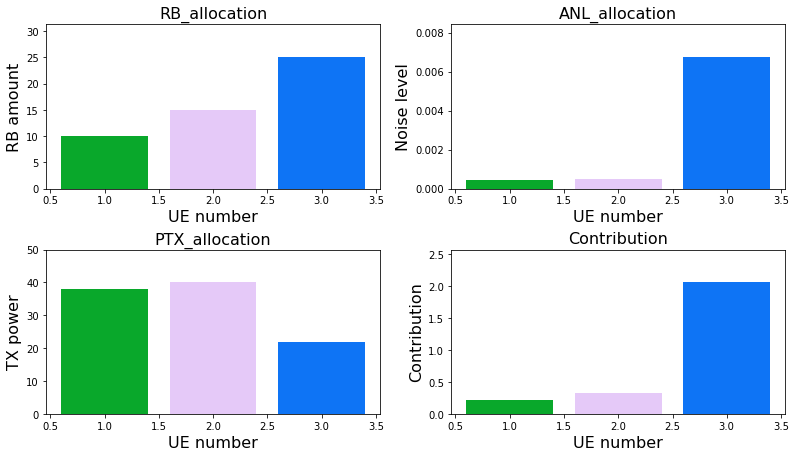

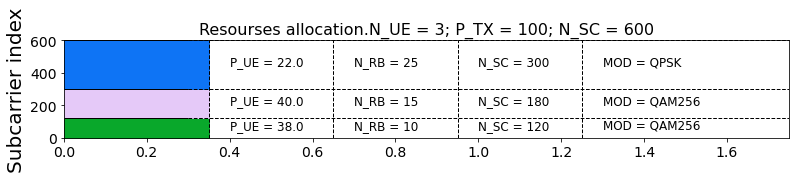

In [111]:
color_list = plots.plot_allocations(RB_allocation,PTX_allocation,ANL_allocation)
plots.plot_res_allocation(np.array(PTX_allocation),np.array(RB_allocation),MOD_allocation,color_list,cfg)

# OFDM signal generation

# Check PAPR

In [112]:
torch.cuda.ipc_collect()
torch.cuda.empty_cache()
D_points = syst.GEN_points(device,MOD_allocation,RB_allocation,cfg,info=False)
S_t,S_f = syst.MOD_signal(D_points,device,MOD_allocation,PTX_allocation,RB_allocation,constellations,cfg,info=True)

PAPR,PAPR_mean0 = syst.get_signal_PAPR(S_t)
print('Initial mean PAPR is ',PAPR_mean0)
print(torch.mean(torch.abs(S_t.cpu())**2))
print(torch.mean(torch.abs(S_f.cpu())**2))
MOD_allocation

The signal has been generated:
Total power =              100.000
OFDM symbols:                  250
IFFT length:                 1024
Mean power in freq dommain = 17.930
Mean power in time dommain = 17.930
Initial mean PAPR is  tensor(8.7618, device='cuda:0')
tensor(17.9297)
tensor(17.9297)


['QAM256', 'QAM256', 'QPSK']

# Max and min PAPR OFDM symbol

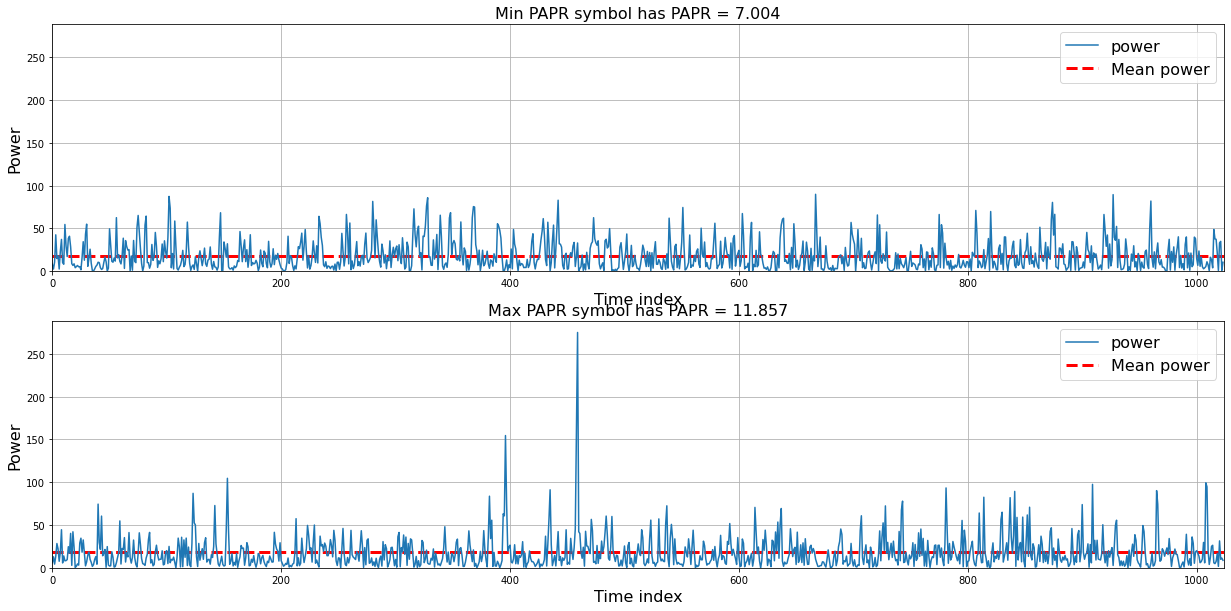

In [113]:
def find_max_min_papr_symbol(S_t,S_f,PAPR):
    min_papr,max_papr = {},{}
    min_papr['index'] = torch.nonzero(PAPR == torch.min(PAPR)).item()
    min_papr['value'] = PAPR[min_papr['index']].item()
    min_papr['symbol_t'] = S_t[:,min_papr['index']].cpu().squeeze()
    min_papr['symbol_f'] = S_f[:,min_papr['index']].cpu().squeeze()
    max_papr['index'] = torch.nonzero(PAPR == torch.max(PAPR))
    max_papr['value'] = PAPR[max_papr['index']].item()
    max_papr['symbol_t'] = S_t[:,max_papr['index']].cpu().squeeze()
    max_papr['symbol_f'] = S_f[:,max_papr['index']].cpu().squeeze()
    return min_papr,max_papr

min_papr,max_papr = find_max_min_papr_symbol(S_t,S_f,PAPR)

fontsize = 16
fig, (ax1, ax2) = plt.subplots(2, 1, sharey=False,figsize=(21,10))
s = torch.max(torch.max(torch.abs(max_papr['symbol_t'])**2),torch.max(torch.abs(max_papr['symbol_t'])**2))
ax1.set_xlim(0,1024)
ax1.set_ylim(0,1.05*s)
ax2.set_xlim(0,1024)
ax2.set_ylim(0,1.05*s)
ax1.set_ylabel('Power',fontsize=fontsize)
ax2.set_ylabel('Power',fontsize=fontsize)
ax1.set_xlabel('Time index',fontsize=fontsize)
ax2.set_xlabel('Time index',fontsize=fontsize)
ax1.plot(torch.abs(min_papr['symbol_t'])**2,label='power')
ax2.plot(torch.abs(max_papr['symbol_t'])**2,label='power')
ax1.set_title('Min PAPR symbol has PAPR = '+str(round(min_papr['value'],3)),fontsize=fontsize)
ax2.set_title('Max PAPR symbol has PAPR = '+str(round(max_papr['value'],3)),fontsize=fontsize)
ax1.grid()
ax2.grid()

ax1.hlines(torch.mean(torch.abs(min_papr['symbol_t'])**2),0,1024,'r','--',linewidth=3,label='Mean power')
ax2.hlines(torch.mean(torch.abs(max_papr['symbol_t'])**2),0,1024,'r','--',linewidth=3,label='Mean power')
ax1.legend(loc='upper right',fontsize=fontsize) 
ax2.legend(loc='upper right',fontsize=fontsize) 
plt.show()

# PAPR probability density function (PDF)

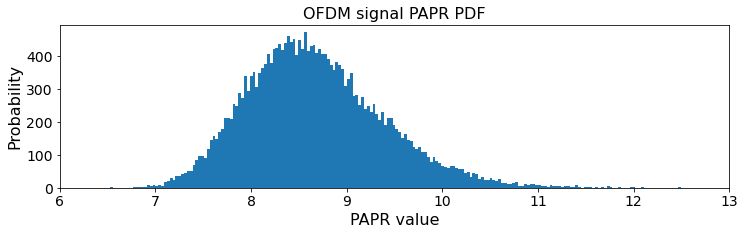

In [114]:
a = []
for i in range(100):
    torch.cuda.ipc_collect()
    torch.cuda.empty_cache()
    D = syst.GEN_points(device,MOD_allocation,RB_allocation,cfg,info=False)
    S_t,S_f = syst.MOD_signal(D,device,MOD_allocation,PTX_allocation,RB_allocation,constellations,cfg,info=False)

    PAPR,PAPR_mean0 = syst.get_signal_PAPR(S_t)
    a.append(np.copy(PAPR.cpu()))

bins = 200
plt.figure(figsize=(12,3))
plt.title('OFDM signal PAPR PDF',fontsize=16)
plt.xlabel('PAPR value',fontsize=16)
plt.ylabel('Probability',fontsize=16)

h = plt.hist(np.array(a).reshape(-1,1)[:], bins, label='Signal amplitude')
# plt.legend(loc='upper right', prop={'size': 14})
plt.xlim(6,13)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [115]:
peak_th = 7
i=0

G0_UE_idx = np.array([i])
G0_ANL = ANL_allocation[i]

# G0_UE_idx = np.array([0,1])
# G0_ANL = np.min(ANL_allocation)

# select subcarriers for PAPR reduction
# G0_SC = syst.GET_GROUP_SC(N_used=N_used,UE_indexes=G0_UE_idx,RB_allocation=torch.tensor(RB_allocation)) + ZERO_SHIFT
G0_SC = np.arange(N_used) + ZERO_SHIFT
# G0_SC = np.array([-100,-50,-10,0,10,50,100,400]) + ZERO_SHIFT

# generate group threshold
G0_group_th = G0_ANL

# choose peak selection thresold
# peak_th = 7
print("Consider as peaks signals exceeding (of mean power): ",10**(peak_th/10))
S_t_reduced = prd.PAPR_reduce(S_t,peak_th,G0_group_th,G0_SC,S_sc,cfg,info=True)

Consider as peaks signals exceeding (of mean power):  5.011872336272722
Pdata/Ptones before supression [-14.04 -14.77 -13.9  -16.64 -17.25 -17.77 -15.94 -14.76 -17.45 -19.15
 -16.69 -18.6  -16.08 -18.99 -21.43 -16.3  -19.9  -13.6  -17.2  -14.4
 -16.43 -15.74 -17.98 -17.09 -19.67 -16.28 -12.63 -17.23 -17.93 -19.04
 -17.06 -16.29 -13.62   -inf -14.4  -16.75 -15.94 -17.43 -16.85 -17.75
 -19.35 -15.17 -16.53 -17.71 -13.71 -12.93 -17.29 -18.   -16.35 -17.15
 -14.21 -17.77 -17.21 -15.14 -19.77 -16.96 -25.19 -13.21 -16.62 -16.92
 -15.42 -20.2  -15.4  -17.08 -15.54 -13.32 -16.14 -16.45 -15.99 -17.35
 -14.98 -14.34 -18.31 -15.23 -14.43 -16.57 -16.26 -16.83 -14.29 -12.62
 -15.71 -12.98 -18.1  -19.51 -16.2  -17.06 -16.42 -25.03 -14.94 -19.73
 -18.8  -14.76 -16.97 -16.31 -15.96 -16.28 -16.42 -16.59 -15.9  -15.41
 -15.03 -18.12 -17.21 -17.01 -17.05 -14.18 -15.68 -16.32 -17.32 -14.07
 -20.3  -13.9  -18.82 -14.97 -16.77 -15.63 -13.74 -17.91 -17.71 -19.46
 -13.94 -13.98 -16.12 -17.11 -16.34 -21.49 -17

functions/papreduce.py:63: RuntimeWarning: divide by zero encountered in true_divide
  print("Pdata/Ptones after supression",np.round(-10*np.log10(np.array((power_data.cpu()/power_tones1))),2))


# th = 7

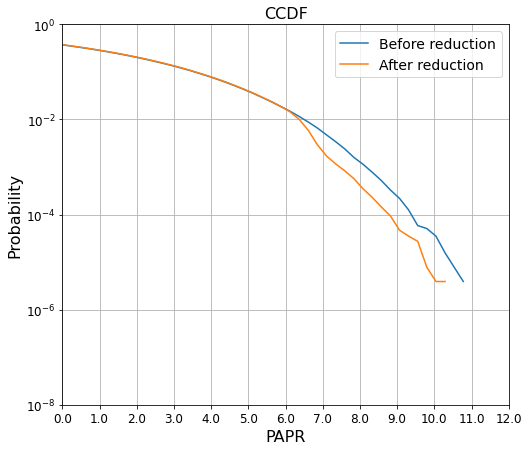

Mean PAPR before reduction: tensor(8.6151, device='cuda:0')
Mean PAPR after reduction: tensor(7.8593, device='cuda:0')
Mean PAPR has been reduced by:  tensor(0.7557, device='cuda:0') dB


In [116]:
LABELS = ["Before reduction","After reduction"]
CCDF1 = ccdf.get_CCDF(papr_range=PAPR_RANGE,S_t=S_t)
CCDF2 = ccdf.get_CCDF(papr_range=PAPR_RANGE,S_t=S_t_reduced)
CCDFs = [plots.filter_ccdf(CCDF1),plots.filter_ccdf(CCDF2)]

plots.plot_CCDF(CCDFs,LABELS,PAPR_RANGE,figsize=(8,7))

PAPR,PAPR_mean1 = syst.get_signal_PAPR(S_t_reduced)
print('Mean PAPR before reduction:',PAPR_mean0)
print('Mean PAPR after reduction:',PAPR_mean1)
print('Mean PAPR has been reduced by: ',PAPR_mean0-PAPR_mean1,'dB')

# th = 4

In [117]:
peak_th = 4
i=0

G0_UE_idx = np.array([i])
G0_ANL = ANL_allocation[i]

# G0_UE_idx = np.array([0,1])
# G0_ANL = np.min(ANL_allocation)

# select subcarriers for PAPR reduction
# G0_SC = syst.GET_GROUP_SC(N_used=N_used,UE_indexes=G0_UE_idx,RB_allocation=torch.tensor(RB_allocation)) + ZERO_SHIFT
G0_SC = np.arange(N_used) + ZERO_SHIFT
# G0_SC = np.array([-100,-50,-10,0,10,50,100,400]) + ZERO_SHIFT

# generate group threshold
G0_group_th = G0_ANL

# choose peak selection thresold
# peak_th = 7
print("Consider as peaks signals exceeding (of mean power): ",10**(peak_th/10))
S_t_reduced = prd.PAPR_reduce(S_t,peak_th,G0_group_th,G0_SC,S_sc,cfg,info=False)

Consider as peaks signals exceeding (of mean power):  2.51188643150958


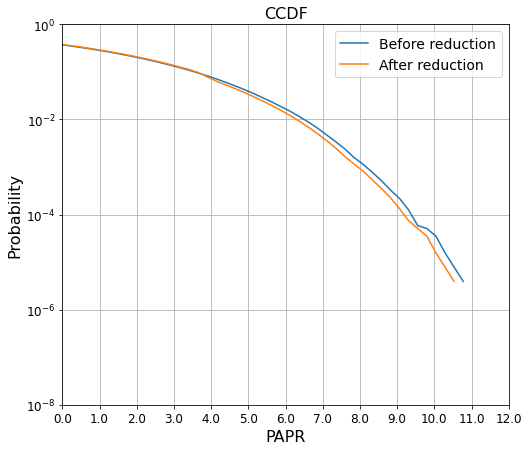

Mean PAPR before reduction: tensor(8.6151, device='cuda:0')
Mean PAPR after reduction: tensor(8.3855, device='cuda:0')
Mean PAPR has been reduced by:  tensor(0.2295, device='cuda:0') dB


In [118]:
LABELS = ["Before reduction","After reduction"]
CCDF1 = ccdf.get_CCDF(papr_range=PAPR_RANGE,S_t=S_t)
CCDF2 = ccdf.get_CCDF(papr_range=PAPR_RANGE,S_t=S_t_reduced)
CCDFs = [(CCDF1),(CCDF2)]

plots.plot_CCDF(CCDFs,LABELS,PAPR_RANGE,figsize=(8,7))

PAPR,PAPR_mean1 = syst.get_signal_PAPR(S_t_reduced)
print('Mean PAPR before reduction:',PAPR_mean0)
print('Mean PAPR after reduction:',PAPR_mean1)
print('Mean PAPR has been reduced by: ',PAPR_mean0-PAPR_mean1,'dB')

# th = 8

In [119]:
peak_th = 7
i=0

G0_UE_idx = np.array([i])
G0_ANL = ANL_allocation[i]

# G0_UE_idx = np.array([0,1])
# G0_ANL = np.min(ANL_allocation)

# select subcarriers for PAPR reduction
G0_SC = syst.GET_GROUP_SC(N_used=N_used,UE_indexes=G0_UE_idx,RB_allocation=torch.tensor(RB_allocation)) + ZERO_SHIFT
# G0_SC = np.arange(N_used) + ZERO_SHIFT
# G0_SC = np.array([-100,-50,-10,0,10,50,100,400]) + ZERO_SHIFT

# generate group threshold
G0_group_th = G0_ANL

# choose peak selection thresold
# peak_th = 7
print("Consider as peaks signals exceeding (of mean power): ",10**(peak_th/10))
# S_t_reduced = prd.PAPR_reduce(S_t,peak_th,G0_group_th,G0_SC,S_sc,cfg,info=False)
S_t_reduced = prd.PAPR_reduce(S_t,peak_th,G0_group_th,G0_SC[:300],S_sc,cfg,info=False)

Consider as peaks signals exceeding (of mean power):  5.011872336272722


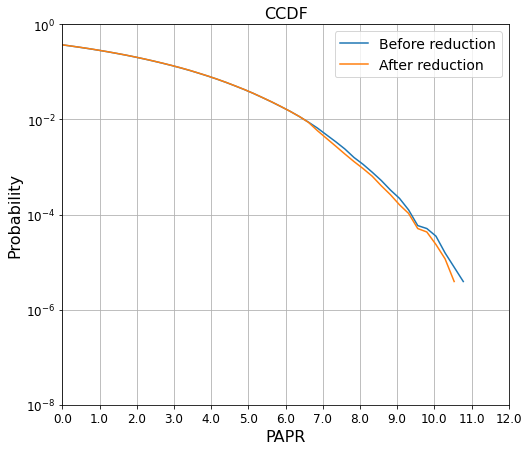

Mean PAPR before reduction: tensor(8.6151, device='cuda:0')
Mean PAPR after reduction: tensor(8.4629, device='cuda:0')
Mean PAPR has been reduced by:  tensor(0.1522, device='cuda:0') dB


In [120]:
LABELS = ["Before reduction","After reduction"]
CCDF1 = ccdf.get_CCDF(papr_range=PAPR_RANGE,S_t=S_t)
CCDF2 = ccdf.get_CCDF(papr_range=PAPR_RANGE,S_t=S_t_reduced)
CCDFs = [(CCDF1),(CCDF2)]

plots.plot_CCDF(CCDFs,LABELS,PAPR_RANGE,figsize=(8,7))

PAPR,PAPR_mean1 = syst.get_signal_PAPR(S_t_reduced)
print('Mean PAPR before reduction:',PAPR_mean0)
print('Mean PAPR after reduction:',PAPR_mean1)
print('Mean PAPR has been reduced by: ',PAPR_mean0-PAPR_mean1,'dB')

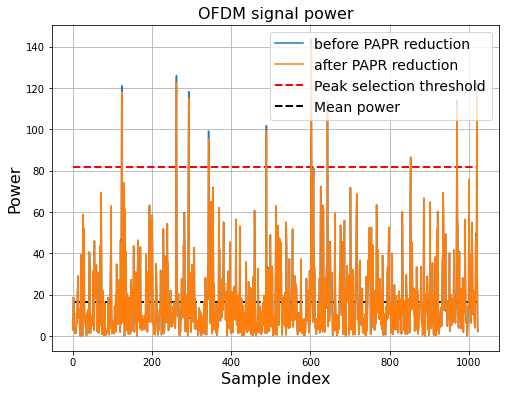

In [121]:
plt.figure(figsize=(8,6))
plt.title('OFDM signal power',fontsize=16)
plt.hlines(np.mean(np.abs(np.array(S_t[1,:128].cpu()))**2)*10**(peak_th/10),0,1024,'r','--',linewidth=2,label='Peak selection threshold')
plt.hlines(np.mean(np.abs(np.array(S_t[1,:128].cpu()))**2),0,1024,'k','--',linewidth=2,label='Mean power')

plt.plot(abs(S_t[:,0].cpu())**2,label='before PAPR reduction')
plt.plot(abs(S_t_reduced[:,0].cpu())**2,label='after PAPR reduction')
plt.legend(loc='upper right', prop={'size': 14})
plt.xlabel('Sample index',fontsize=16)
plt.ylabel('Power',fontsize=16)
plt.grid()

In [122]:
PSD = torch.sum(torch.abs(S_t)**2,axis=0)/N_used
-10*torch.log10(PSD.cpu()/(np.sum(np.abs(np.array((S_t-S_t_reduced).cpu()))**2,axis=0)/G0_SC.shape[0]))[:99]

<ipython-input-122-e9114959257f>:2: RuntimeWarning: divide by zero encountered in true_divide
  -10*torch.log10(PSD.cpu()/(np.sum(np.abs(np.array((S_t-S_t_reduced).cpu()))**2,axis=0)/G0_SC.shape[0]))[:99]


tensor([-33.3208, -33.3208, -33.3208, -33.3208, -33.3208, -33.3208, -33.3208,
        -33.3208, -33.3208, -33.3208, -33.3208, -33.3208, -33.3208, -33.3208,
        -33.3208, -33.3208, -33.3208, -33.3208, -33.3208, -33.3208, -33.3208,
        -33.3208, -33.3208, -33.3208, -33.3208, -33.3208, -33.3208, -33.3208,
        -33.3208, -33.3208, -33.3208, -33.3208, -33.3208,     -inf, -33.3208,
        -33.3208, -33.3208, -33.3208, -33.3208, -33.3208, -33.3208, -33.3208,
        -33.3208, -33.3208, -33.3208, -33.3208, -33.3208, -33.3208, -33.3208,
        -33.3208, -33.3208, -33.3208, -33.3208, -33.3208, -33.3208, -33.3208,
        -33.3208, -33.3208, -33.3208, -33.3208, -33.3208, -33.3208, -33.3208,
        -33.3208, -33.3208, -33.3208, -33.3208, -33.3208, -33.3208, -33.3208,
        -33.3208, -33.3208, -33.3208, -33.3208, -33.3208, -33.3208, -33.3208,
        -33.3208, -33.3208, -33.3208, -33.3208, -33.3208, -33.3208, -33.3208,
        -33.3208, -33.3208, -33.3208, -33.3208, -33.3208, -33.32

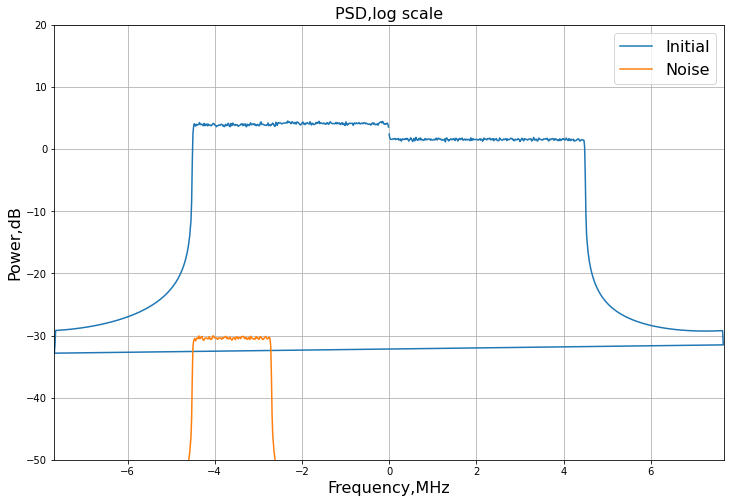

(['QAM256', 'QAM256', 'QPSK'],
 array([-33.32080315, -33.0980392 , -21.71501222]))

In [123]:
SIGNALS = [S_t,(S_t-S_t_reduced)]
LABELS=['Initial','Noise']
TITLE='PSD,log scale'

PSD=plots.plot_spectrum(SIGNALS,LABELS,TITLE,Fs,cfg)
MOD_allocation,10*np.log10(ANL_allocation)

Allowed EVM =  -21.71501221805205
Real    EVM =  -40.32774191090307


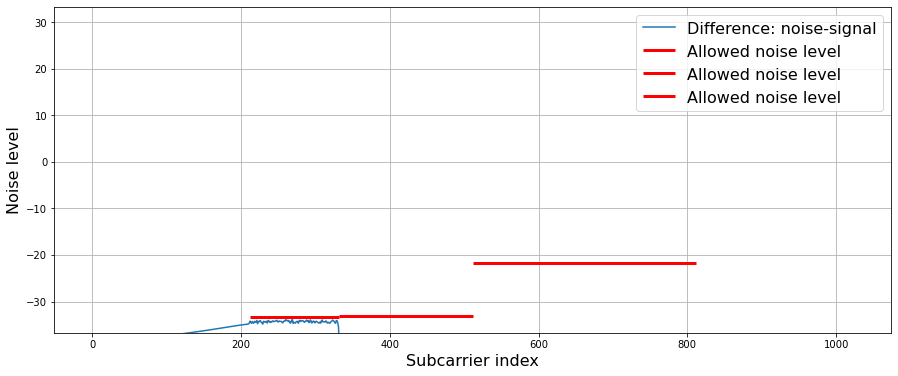

In [124]:
sc=np.arange(1024)
plt.figure(figsize=(15,6))
psd = -10*np.log10(PSD[0][0][sc])+10*np.log10(PSD[1][0][sc])
plt.plot(psd,label = 'Difference: noise-signal')
SC = syst.GET_UE_SC_idx(torch.tensor(RB_allocation))+ZERO_SHIFT
# plt.vlines(np.array([ZERO_SHIFT,ZERO_SHIFT+N_used]),-50,10,colors='k',linewidth=0.5)
for i in range(len(SC)-1):
    plt.hlines(10*np.log10(ANL_allocation[i]),SC[i],SC[i+1],colors='r',linewidth=3,label = 'Allowed noise level')
    
plt.ylabel('Noise level',fontsize=16)
plt.xlabel('Subcarrier index',fontsize=16)
plt.ylim(10*np.log10(ANL_allocation[i])-15,10*np.log10(ANL_allocation[i])+55)
plt.legend(fontsize=16)
plt.grid()

print('Allowed EVM = ',10*np.log10(ANL_allocation[i]))
print('Real    EVM = ',10*np.log10((torch.sum(torch.abs(S_t_reduced - S_t)**2)/torch.sum(torch.abs(S_t)**2)).cpu().item()))

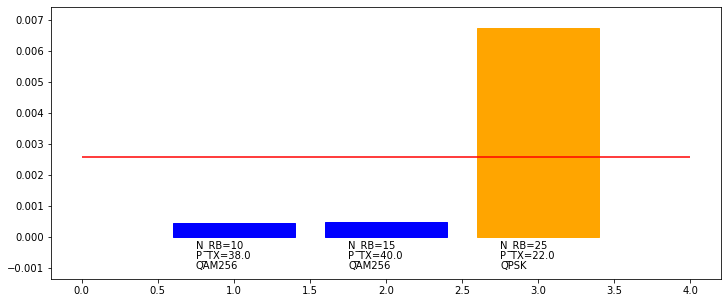

In [125]:
k=1
th = k*np.mean(ANL_allocation)

plt.figure(figsize=(12,5))
plt.hlines(th,0,N_UE+1,'r')
plt.ylim(-0.2*np.max(ANL_allocation),1.1*np.max(ANL_allocation))

bar = plt.bar(np.arange(N_UE)+1,ANL_allocation)

G1_UE_idx = np.nonzero(ANL_allocation > th)[0].astype(int)
G2_UE_idx = np.nonzero(ANL_allocation <= th)[0].astype(int)

# G1_UE_idx = np.array([0])
# G2_UE_idx = np.array([1])

for i in G1_UE_idx:
    bar[i].set_color('orange')
for i in G2_UE_idx:
    bar[i].set_color('blue')
    
for i in range(len(ANL_allocation)):
    plt.text(i+0.75,-0.05*np.max(ANL_allocation),'N_RB='+str(RB_allocation[i]))
    plt.text(i+0.75,-0.1*np.max(ANL_allocation),'P_TX='+str(PTX_allocation[i]))
    plt.text(i+0.75,-0.15*np.max(ANL_allocation),str(MOD_allocation[i]))

# PAPR reduction for several groups

In [126]:
G1_UE_idx_=np.array([0])#np.copy(G1_UE_idx[:])
G2_UE_idx_=np.array([1])#np.copy(G2_UE_idx[:])
G3_UE_idx_=np.array([2])#np.copy(G3_UE_idx[:])
th = 6.75
th = 7
peak_th = th
G1_group_th = np.min(ANL_allocation[G1_UE_idx_])
G1_SC = syst.GET_GROUP_SC(N_used=N_used,UE_indexes=G1_UE_idx_,RB_allocation=torch.tensor(RB_allocation)) + ZERO_SHIFT
S_t_reduced = prd.PAPR_reduce(S_t,peak_th,G1_group_th,G1_SC,S_sc,cfg,info=False)
th = 6.5
peak_th = th
G2_group_th = np.min(ANL_allocation[G2_UE_idx_])
G2_SC = syst.GET_GROUP_SC(N_used=N_used,UE_indexes=G2_UE_idx_,RB_allocation=torch.tensor(RB_allocation)) + ZERO_SHIFT
S_t_reduced = prd.PAPR_reduce(S_t_reduced,peak_th,G2_group_th,G2_SC,S_sc,cfg,info=False)
th = 6
peak_th = th
G3_group_th = np.min(ANL_allocation[G3_UE_idx_])
G3_SC = syst.GET_GROUP_SC(N_used=N_used,UE_indexes=G3_UE_idx_,RB_allocation=torch.tensor(RB_allocation)) + ZERO_SHIFT
S_t_reduced = prd.PAPR_reduce(S_t_reduced,peak_th,G3_group_th,G3_SC,S_sc,cfg,info=False)

PAPR,PAPR_mean1 = syst.get_signal_PAPR(S_t_reduced)
print('Mean PAPR before reduction:',PAPR_mean0)
print('Mean PAPR after reduction:',PAPR_mean1)
print('Mean PAPR has been reduced by: ',PAPR_mean0-PAPR_mean1,'dB')

Mean PAPR before reduction: tensor(8.6151, device='cuda:0')
Mean PAPR after reduction: tensor(7.3605, device='cuda:0')
Mean PAPR has been reduced by:  tensor(1.2546, device='cuda:0') dB


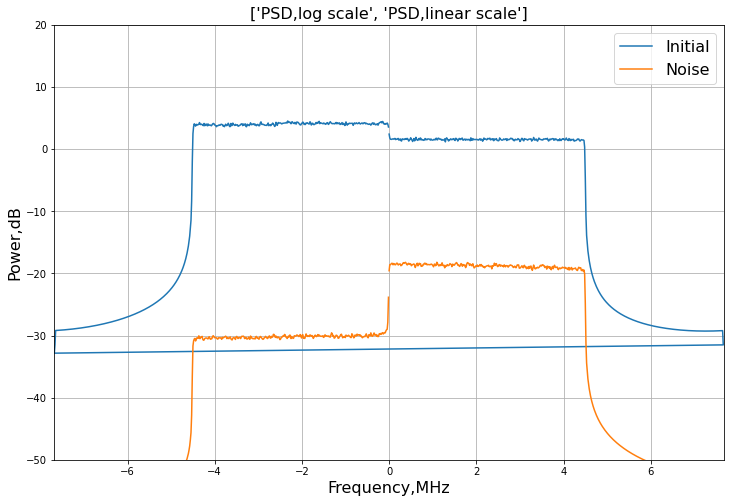

In [127]:
# SIGNALS = [S_t,S_t-S_t_reduced1,S_t-S_t_reduced2]
SIGNALS = [S_t,(S_t-S_t_reduced)]
LABELS=['Initial','Noise']
TITLES=['PSD,log scale','PSD,linear scale']
PSD = plots.plot_spectrum(SIGNALS,LABELS,TITLES,Fs,cfg)


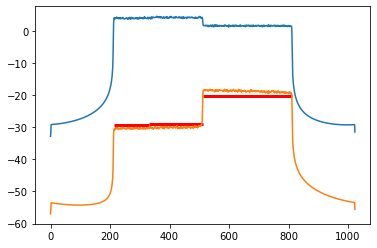

In [128]:
plt.plot(10*np.log10(np.array(PSD[0])[0,:]))
plt.plot(10*np.log10(np.array(PSD[1])[0,:]))
for i in range(len(SC)-1):
    allowed_level = 10*np.log10(ANL_allocation[i])
    top_level = 10*np.log10(np.array(PSD[0])[0,SC[i]:SC[i+1]]).mean()
    plt.hlines(top_level+allowed_level,SC[i],SC[i+1],colors='r',linewidth=3)

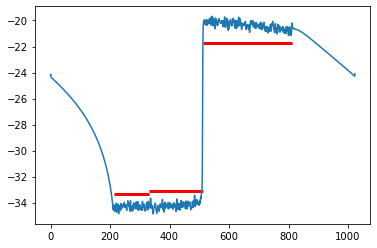

In [131]:
plt.plot(-10*np.log10(PSD[0].T)+10*np.log10(PSD[1].T))
for i in range(len(SC)-1):
    plt.hlines(10*np.log10(ANL_allocation[i]),SC[i],SC[i+1],colors='r',linewidth=3)

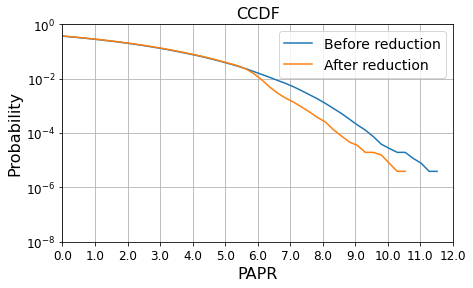

PAPR_mean before reduction tensor(8.6678, device='cuda:0')
PAPR_mean after reduction tensor(7.6647, device='cuda:0')
Delta =  tensor(1.0031, device='cuda:0')


In [109]:
LABELS = ["Before reduction","After reduction"]
CCDF1 = ccdf.get_CCDF(papr_range=PAPR_RANGE,S_t=S_t)
CCDF2 = ccdf.get_CCDF(papr_range=PAPR_RANGE,S_t=S_t_reduced)
CCDF = [CCDF1,CCDF2]

plots.plot_CCDF(CCDF,LABELS,PAPR_RANGE,figsize=(7,4))

PAPR,PAPR_mean2 = syst.get_signal_PAPR(S_t_reduced)
print('PAPR_mean before reduction',PAPR_mean0)
print('PAPR_mean after reduction',PAPR_mean2)
print('Delta = ',PAPR_mean0-PAPR_mean2)